In [5]:
import importlib
import os

from datasets import load_dataset
import tiktoken
from transformers import AutoModelForCausalLM, AutoTokenizer

from nanoGPT import model
import utils as ut
import pipelines as p

wikitext = load_dataset("wikitext", "wikitext-2-v1")

hf_gpt_model = AutoModelForCausalLM.from_pretrained("gpt2")
hf_gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2")

# nanoGPT_model = model.GPT.from_pretrained("gpt2", dict(dropout=0))
# nanoGPT_model.eval()
# tiktoken_tokenizer = tiktoken.get_encoding("gpt2")


Found cached dataset wikitext (/Users/jdvin/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
"""Create various optimised and quantised models for testing.

Sources:
        - https://onnxruntime.ai/docs/performance/quantization.html
        - https://github.com/microsoft/onnxruntime-inference-examples/blob/main/quantization/notebooks/bert/Bert-GLUE_OnnxRuntime_quantization.ipynb
"""


os.makedirs("models", exist_ok=True)
models = os.listdir("./models/")

if "models" in os.listdir() and "gpt2_past.onnx" in models:

    if "gpt2_opt.onnx" not in models:
        from onnxruntime_tools import optimizer # Transformer specific optimisation tools.
        opt_model = optimizer.optimize_model(
            "models/gpt2_past.onnx",
            "gpt2",
            num_heads=hf_gpt_model.config.n_head,
            hidden_size=hf_gpt_model.config.n_embd,
        )
        opt_model.save_model_to_file("models/gpt2_opt.onnx")


    from onnxruntime.quantization import quantize_dynamic
    if "gpt2_quant.onnx" not in models:
        quant_model = quantize_dynamic("models/gpt2_past.onnx", "models/gpt2_quant.onnx")
    if "gpt_opt_quant.onnx" not in models:
        opt_quant_model = quantize_dynamic("models/gpt2_opt.onnx", "models/gpt2_opt_quant.onnx")

else:
    raise Exception("You have not compiled the base GPT2 onnx model. Refer to `README.md`.")


=== Beginning Model Testing ===
=> Testing model HF Base (1/5).
==> Running speed test...


  0%|          | 0/20 [00:00<?, ?it/s]

==> Complete!
==> Running perplexity test...


  0%|          | 0/10 [00:00<?, ?it/s]

==> Complete!
=> Testing model Onnx Base (2/5).
==> Running speed test...


  0%|          | 0/20 [00:00<?, ?it/s]

==> Complete!
==> Running perplexity test...


  0%|          | 0/10 [00:00<?, ?it/s]

==> Complete!
=> Testing model Onnx Opt (3/5).
==> Running speed test...


  0%|          | 0/20 [00:00<?, ?it/s]

==> Complete!
==> Running perplexity test...


  0%|          | 0/10 [00:00<?, ?it/s]

==> Complete!
=> Testing model Onnx Quan (4/5).
==> Running speed test...


  0%|          | 0/20 [00:00<?, ?it/s]

==> Complete!
==> Running perplexity test...


  0%|          | 0/10 [00:00<?, ?it/s]

==> Complete!
=> Testing model Onnx Opt Quan (5/5).
==> Running speed test...


  0%|          | 0/20 [00:00<?, ?it/s]

==> Complete!
==> Running perplexity test...


  0%|          | 0/10 [00:00<?, ?it/s]

==> Complete!
== Model Testing Complete! - Plotting results... ==


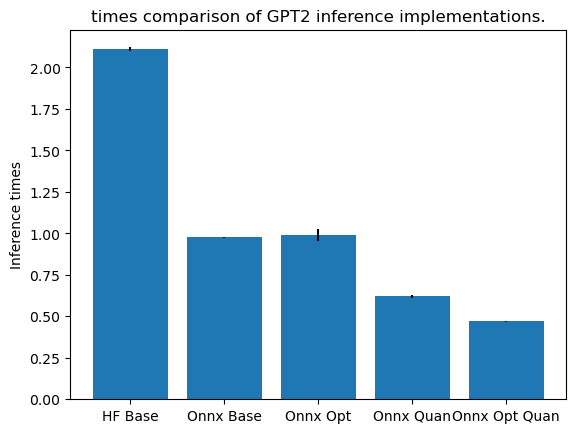

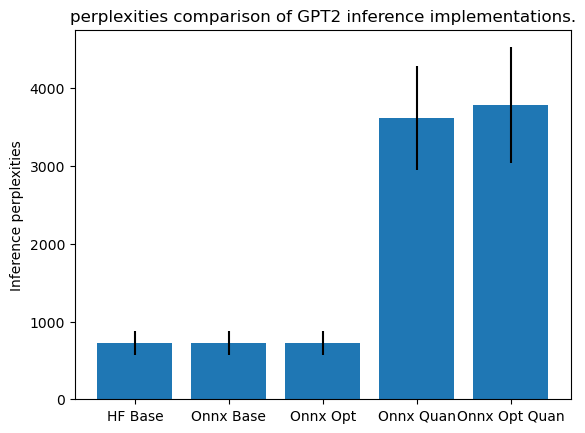

In [60]:
importlib.reload(ut)
importlib.reload(p)

base_hf_tester = ut.ModelTester(
    model_name="HF Base",
    model_func=p.huggingface_pipe(tokenizer=hf_gpt_tokenizer, model=hf_gpt_model),
)

# nanoGPT_tester = p.ModelTester(
#     model_name="nanoGPT",
#     model_func=p.nanoGPT_pipe(tiktoken_tokenizer, nanoGPT_model),
# )


onnx_base_tester = ut.ModelTester(
    model_name="Onnx Base",
    model_func=p.onnx_custom_pipe(
        hf_gpt_tokenizer,
        model_path="models/gpt2_base.onnx",
        n_attention_heads=hf_gpt_model.config.n_head,
        hidden_size=hf_gpt_model.config.n_embd,
        n_layers=hf_gpt_model.config.n_layer,
    ),
)
onnx_quant_tester = ut.ModelTester(
    model_name="Onnx Quan",
    model_func=p.onnx_custom_pipe(
        hf_gpt_tokenizer,
        model_path="models/gpt2_quant.onnx",
        n_attention_heads=hf_gpt_model.config.n_head,
        hidden_size=hf_gpt_model.config.n_embd,
        n_layers=hf_gpt_model.config.n_layer,
    ),
)

onnx_opt_tester = ut.ModelTester(
    model_name="Onnx Opt",
    model_func=p.onnx_custom_pipe(
        hf_gpt_tokenizer,
        model_path="models/gpt2_opt.onnx",
        n_attention_heads=hf_gpt_model.config.n_head,
        hidden_size=hf_gpt_model.config.n_embd,
        n_layers=hf_gpt_model.config.n_layer,
    ),
)
onnx_opt_quant_tester = ut.ModelTester(
    model_name="Onnx Opt Quan",
    model_func=p.onnx_custom_pipe(
        hf_gpt_tokenizer,
        model_path="models/gpt2_opt_quant.onnx",
        n_attention_heads=hf_gpt_model.config.n_head,
        hidden_size=hf_gpt_model.config.n_embd,
        n_layers=hf_gpt_model.config.n_layer,
    ),
)

testers = [
    base_hf_tester,
    onnx_base_tester,
    onnx_opt_tester,
    onnx_quant_tester,
    onnx_opt_quant_tester,
]

tests_per_model = 20
prompt_length = 50
test_sequences = ut.sample_dataset(
    dataset=wikitext, n_articles=10, min_length_chars=500, max_length_chars=1000
)
standard_sequences = [
    "The Wright brothers invented and flew the first airplane in 1903, recognized as 'the first sustained and controlled heavier-than-air powered flight'. They built on the works of George Cayley dating from 1799, when he set forth the concept of the modern airplane (and later built and flew models and successful passenger-carrying gliders). Between 1867 and 1896, the German pioneer of human aviation Otto Lilienthal also studied heavier-than-air flight. Following its limited use in World War I, aircraft technology continued to develop. Airplanes had a presence in all the major battles of World War II. The first jet aircraft was the German Heinkel He 178 in 1939. The first jet airliner, the de Havilland Comet, was introduced in 1952. The Boeing 707, the first widely successful commercial jet, was in commercial service for more than 50 years, from 1958 to at least 2013.",
    "Telecommunications is about transferring information from one location to another. This includes many forms of information: telephone conversations, television signals, computer files, and other types of data. To transfer the information, you need a channel between the two locations. This may be a wire pair, radio signal, optical fiber, etc. Telecommunications companies receive payment for transferring their customer's information, while they must pay to establish and maintain the channel. The financial bottom line is simple: the more information they can pass through a single channel, the more money they make. DSP has revolutionized the telecommunications industry in many areas: signaling tone generation and detection, frequency band shifting, filtering to remove power line hum, etc. Three specific examples from the telephone network will be discussed here: multiplexing, compression, and echo control.",
]
max_generation_length = 100


# random.shuffle(testers)
print("=== Beginning Model Testing ===")
for i, model_tester in enumerate(testers):
    print(f"=> Testing model {model_tester.model_name} ({i+1}/{len(testers)}).")
    print(f"==> Running speed test...")
    # Conduct multiple tests to account for variance resulting from machine-level sources.
    model_tester.run_speed_test(
        n_tests=tests_per_model,
        prompt_length=prompt_length,
        max_generation_length=max_generation_length,
        tokenizer=hf_gpt_tokenizer,
    )
    print(f"==> Complete!")
    print(f"==> Running perplexity test...")
    model_tester.run_perplexity_test(test_sequences, hf_gpt_tokenizer)
    print(f"==> Complete!")

print("== Model Testing Complete! - Plotting results... ==")
ut.plot_test_results(model_testers=testers, result_type="times")
ut.plot_test_results(model_testers=testers, result_type="perplexities")


testers[0].outputs


Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

Performing test 1/30...


  0%|          | 0/5 [00:00<?, ?it/s]

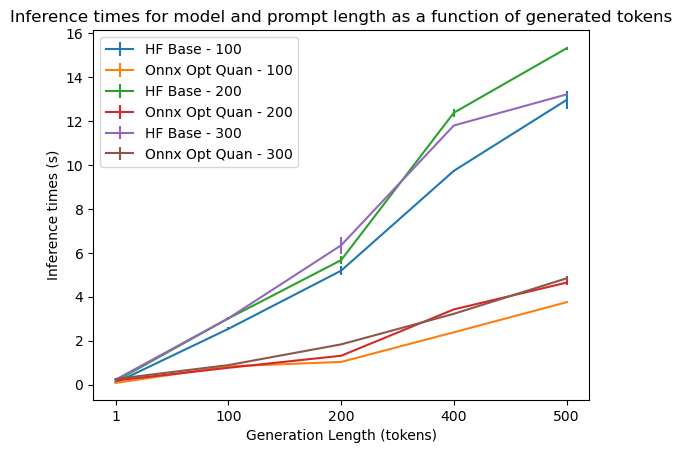

In [62]:
"""Perform secondary analysis on how model performance varies as a function of input and generation length."""

from collections import defaultdict
import math
importlib.reload(ut)

tests_per_model = 5
prompt_lengths = [100, 200, 300]
generation_lengths = [1, 100, 200, 400, 500]

# Taking the base model and best performer from the initial analysis.
testers = [base_hf_tester, onnx_opt_quant_tester]
result_logs = defaultdict(list)
"""Constructing test logs in the following schema:
{   # Key for each inference function - prompt length pair.
            <test label> :
            [ # Array for each different generation length.
                [# Float for each test repetition within generation length.
                    0.1,
                    ...
                ],
                ...
            ],
            ...
}
"""
n_tests = len(prompt_lengths) * len(generation_lengths) * len(testers)
i = 0
for prompt_length in prompt_lengths:
    for gen_length in generation_lengths:
        for tester in testers:
            print(f"Performing test {i+1}/{n_tests}...")
            tester.run_speed_test(
                n_tests=tests_per_model,
                prompt_length=prompt_length,
                max_generation_length=gen_length,
                tokenizer=hf_gpt_tokenizer
            )
            result_logs[f'{tester.model_name} - {prompt_length}'].append(tester.times)
            tester.times = []
            i+=1

ut.plot_varied_speed_test(tester_results=result_logs, generation_lengths=generation_lengths)